# Epoch-Wise Double Descent with WeightWatcher

Here, we train a 3-layer MLP (MLP3) on MNIST using all the 'known tricks' to get to very high test accuracy (99.4%)

In particular, we augment the training data on each batch with small random rotations, translations, and rescalings.

The model is trained for 100 epochs, and we measure the test and 'augmented' training accuracy and the layer alphas $\alpha$.
The 'augmented' training accuracy is evaluated on the augmented training data.

The accuracy curves display the signatures of epoch-wise Double Descent.  Both the test accuracy (orange)  increases to a local maximum, then dips down, and then increases again.  At the same time, the augmented training accuracy increases to about $97%$ (and is no where near 100%, as expected), and then collapses to $90%$.  

When the test accuracy first peaks, the  layer alphas all approach their theoretically predicted ideal value $\alpha\rightarrow 2$.   The model is optimal here.

When the test accuracy dips, the alphas dip into the overfit phase, $\alpha \lt 2$, and stay there.  The model is now in the overfit regime.  And it can not longer effectively generalize to out-of-distribution data.

But it's not the test accuracy (orange) it fails on.  It does great there. it's the  randonly augmented training data (blue) that it can no longer describe! That's the true out-of-distribution data.

Another example of weightwatcher in action! 

In [45]:
#!pip -q install torch torchvision pandas matplotlib weightwatcher

import os, math, time, random
from dataclasses import dataclass
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib
import weightwatcher as ww

%matplotlib inline
import matplotlib.pyplot as plt


# =========================
# Repro + device
# =========================
def set_seed(s):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import os
OUTDIR = "./runs/mlp3_mnist_dd"
os.makedirs(OUTDIR, exist_ok=True)

SMALL N PL FIT
Epoch 01/100  train_loss 0.6711  train_acc 87.77%  train_clean_acc 96.41%  test_acc 96.73%  LRs [0.0008, 0.0016]  (20.0s)
SMALL N PL FIT
Epoch 02/100  train_loss 0.4724  train_acc 94.85%  train_clean_acc 97.91%  test_acc 97.83%  LRs [0.0016, 0.0032]  (14.0s)
SMALL N PL FIT
Epoch 03/100  train_loss 0.4685  train_acc 94.90%  train_clean_acc 97.74%  test_acc 97.72%  LRs [0.0024, 0.0048]  (11.7s)
SMALL N PL FIT
Epoch 04/100  train_loss 0.4665  train_acc 95.11%  train_clean_acc 97.94%  test_acc 97.84%  LRs [0.002399, 0.004799]  (12.0s)
SMALL N PL FIT
Epoch 05/100  train_loss 0.4421  train_acc 95.77%  train_clean_acc 98.39%  test_acc 98.20%  LRs [0.002398, 0.004795]  (12.1s)
SMALL N PL FIT
Epoch 06/100  train_loss 0.4275  train_acc 96.23%  train_clean_acc 98.62%  test_acc 98.43%  LRs [0.002394, 0.004789]  (12.8s)
SMALL N PL FIT
Epoch 07/100  train_loss 0.4155  train_acc 96.69%  train_clean_acc 98.75%  test_acc 98.71%  LRs [0.00239, 0.00478]  (13.1s)
SMALL N PL FIT
Epoch 08/100

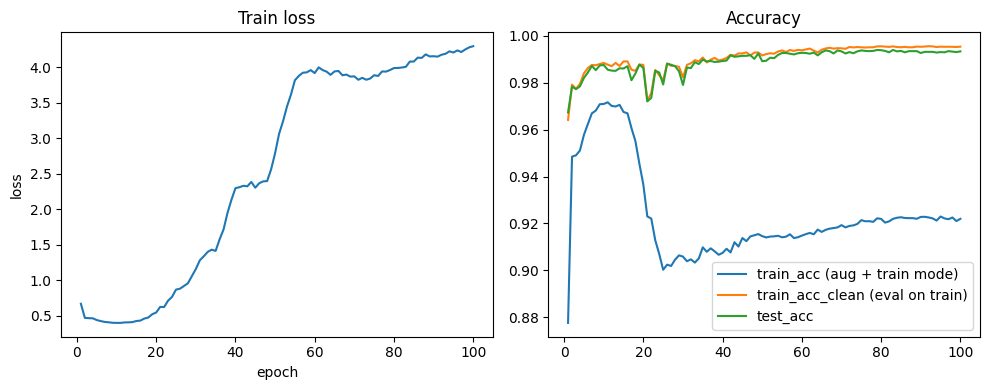

In [37]:
# =========================
# Hyperparameters
# =========================
@dataclass
class HParams:
    hidden1: int = 1792
    hidden2: int = 896
    dropout: float = 0.15

    epochs: int = 100
    batch_size: int = 256
    base_lr: float = 3e-3
    head_lr_mul: float = 1.6
    stem_lr_mul: float = 0.8
    weight_decay: float = 1.0e-4
    warmup_epochs: int = 3
    min_lr_ratio: float = 0.01
    label_smoothing: float = 0.05
    clip_grad_norm: float = 0.0

    # augmentation
    degrees: float = 10.0
    translate: tuple = (0.1, 0.1)
    scale: tuple = (0.95, 1.05)
    random_erasing: float = 0.05

    num_workers: int = 2
    seed: int = 24
    amp: bool = True
    out_dir: str = OUTDIR

hp = HParams()

set_seed(hp.seed)

# =========================
# Model
# =========================
class MLP3(nn.Module):
    def __init__(self, h1=1024, h2=512, drop=0.2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stem = nn.Sequential(
            nn.Linear(28*28, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
        )
        self.head = nn.Linear(h2, 10)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.stem(x)
        x = self.head(x)
        return x

# =========================
# Scheduler: Warmup + Cosine
# =========================
class WarmupCosine:
    def __init__(self, opt, max_epochs, warmup, min_ratio=0.02):
        self.opt = opt; self.max = max_epochs; self.warm = warmup; self.min = min_ratio
        self.e = 0
        self.base = [pg.get("initial_lr", pg["lr"]) for pg in opt.param_groups]
    def step(self):
        self.e += 1
        for base, pg in zip(self.base, self.opt.param_groups):
            if self.e <= self.warm:
                lr = base * self.e / max(1, self.warm)
            else:
                t = (self.e - self.warm) / max(1, self.max - self.warm)
                lr = base * (self.min + 0.5*(1-self.min)*(1+math.cos(math.pi*t)))
            pg["lr"] = lr
    def get_lrs(self): return [pg["lr"] for pg in self.opt.param_groups]

# =========================
# Data
# =========================
train_tf = [
    transforms.RandomAffine(degrees=hp.degrees, translate=hp.translate, scale=hp.scale),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]
if hp.random_erasing > 0:
    train_tf.append(transforms.RandomErasing(p=hp.random_erasing, scale=(0.02, 0.1), ratio=(0.3, 3.3)))

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST("./data", train=True, download=True,
                          transform=transforms.Compose(train_tf))
test_ds  = datasets.MNIST("./data", train=False, download=True,
                          transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=hp.batch_size, shuffle=True,
                          num_workers=hp.num_workers, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=1024, shuffle=False,
                          num_workers=hp.num_workers, pin_memory=True)

# NEW: clean train loader (no augmentation) for "true" train accuracy
clean_train_ds = datasets.MNIST("./data", train=True, download=False,
                                transform=test_tf)
clean_train_loader = DataLoader(clean_train_ds, batch_size=1024, shuffle=False,
                                num_workers=hp.num_workers, pin_memory=True)

# =========================
# Train & Eval
# =========================
def accuracy(logits, y):
    with torch.no_grad():
        return (logits.argmax(1) == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / total

def train_one_epoch(model, loader, opt, scaler):
    model.train()
    loss_fn = nn.CrossEntropyLoss(label_smoothing=hp.label_smoothing)
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        if hp.amp:
            with torch.autocast(device_type=device.type,
                                dtype=torch.float16 if device.type=="cuda" else torch.bfloat16):
                out = model(x)
                loss = loss_fn(out, y)
            scaler.scale(loss).backward()
            if hp.clip_grad_norm > 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), hp.clip_grad_norm)
            scaler.step(opt)
            scaler.update()
        else:
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            if hp.clip_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), hp.clip_grad_norm)
            opt.step()
        total_loss += loss.item()
        total_acc += accuracy(out, y)
        n += 1
    return total_loss/n, total_acc/n

# =========================
# Setup training
# =========================
model = MLP3(hp.hidden1, hp.hidden2, hp.dropout).to(device)
pgs = [
    {"params": list(model.stem.parameters()),
     "lr": hp.base_lr*hp.stem_lr_mul,
     "initial_lr": hp.base_lr*hp.stem_lr_mul,
     "weight_decay": hp.weight_decay},
    {"params": list(model.head.parameters()),
     "lr": hp.base_lr*hp.head_lr_mul,
     "initial_lr": hp.base_lr*hp.head_lr_mul,
     "weight_decay": hp.weight_decay}
]
opt = torch.optim.AdamW(pgs, betas=(0.9, 0.999), eps=1e-8)
sched = WarmupCosine(opt, hp.epochs, hp.warmup_epochs, hp.min_lr_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=hp.amp and device.type=="cuda")

# =========================
# Run training
# =========================
best_acc, history = 0, []
ww_history = []
t0 = time.time()
for epoch in range(1, hp.epochs+1):
    t1 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, opt, scaler)
    test_acc = evaluate(model, test_loader)
    train_clean_acc = evaluate(model, clean_train_loader)  # NEW: true train acc

    # ---- WeightWatcher analysis for this epoch ----
    watcher = ww.WeightWatcher(model=model)
    ww_df = watcher.analyze(plot=False, savefig=False)
    ww_df["epoch"] = epoch
    ww_history.append(ww_df)

    sched.step()
    lrs = sched.get_lrs()
    history.append(dict(
        epoch=epoch,
        train_loss=train_loss,
        train_acc=train_acc,
        train_clean_acc=train_clean_acc,   # NEW
        test_acc=test_acc,
        lr_stem=lrs[0],
        lr_head=lrs[1],
    ))
    print(
        f"Epoch {epoch:02d}/{hp.epochs}  "
        f"train_loss {train_loss:.4f}  "
        f"train_acc {train_acc*100:5.2f}%  "
        f"train_clean_acc {train_clean_acc*100:5.2f}%  "  # NEW
        f"test_acc {test_acc*100:5.2f}%  "
        f"LRs {[round(l,6) for l in lrs]}  "
        f"({time.time()-t1:.1f}s)"
    )
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(
            {"model": model.state_dict(), "epoch": epoch, "acc": best_acc},
            os.path.join(hp.out_dir, "model_best.pt"),
        )

print(f"\nDone in {time.time()-t0:.1f}s. Best test acc: {best_acc*100:.2f}%")

# =========================
# Save logs & plot
# =========================
df = pd.DataFrame(history)
df.to_csv(os.path.join(hp.out_dir, "training_log.csv"), index=False)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(df["epoch"], df["train_loss"])
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Train loss")

plt.subplot(1,2,2)
plt.plot(df["epoch"], df["train_acc"],        label="train_acc (aug + train mode)")
plt.plot(df["epoch"], df["train_clean_acc"], label="train_acc_clean (eval on train)")  # NEW
plt.plot(df["epoch"], df["test_acc"],        label="test_acc")
plt.legend(); plt.title("Accuracy")

plt.tight_layout()
plt.savefig(os.path.join(hp.out_dir, "training_curves.png"), dpi=140)
print("Saved logs and plots in:", hp.out_dir)

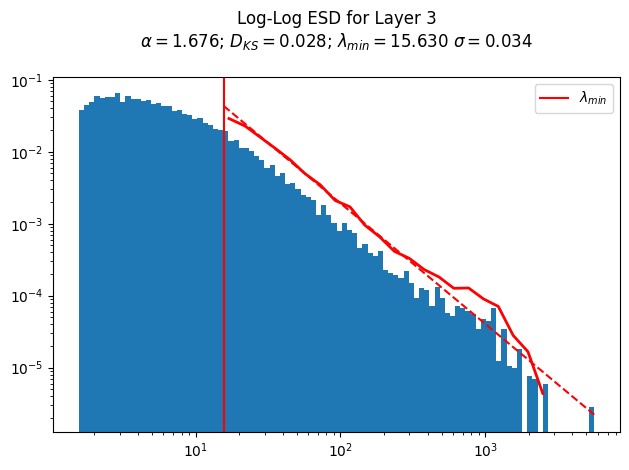

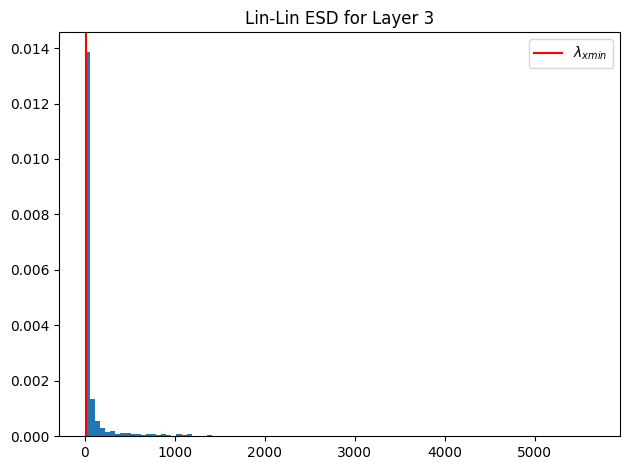

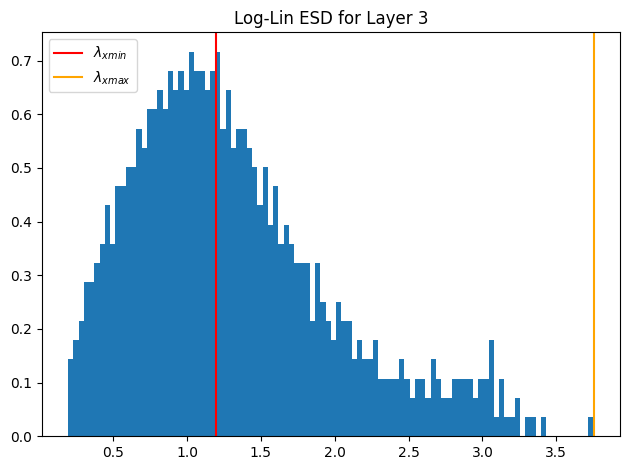

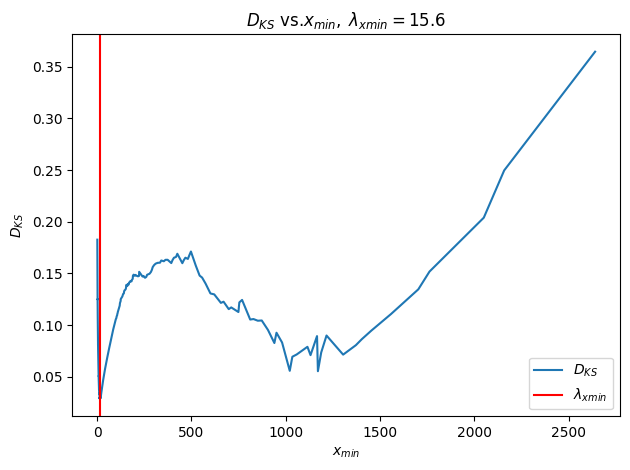

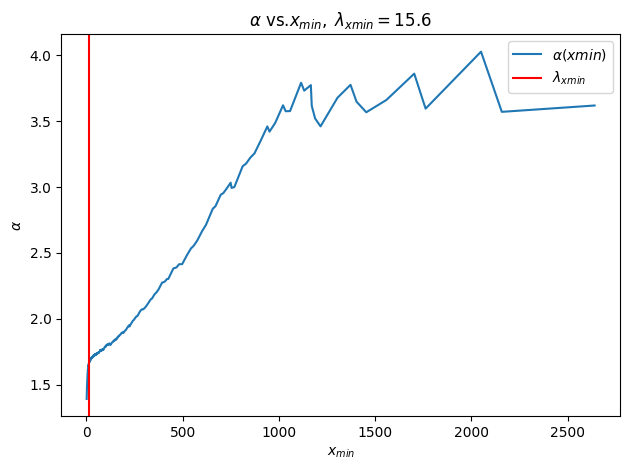

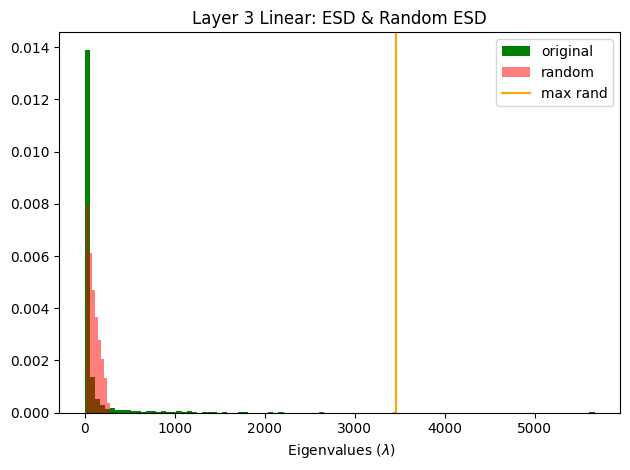

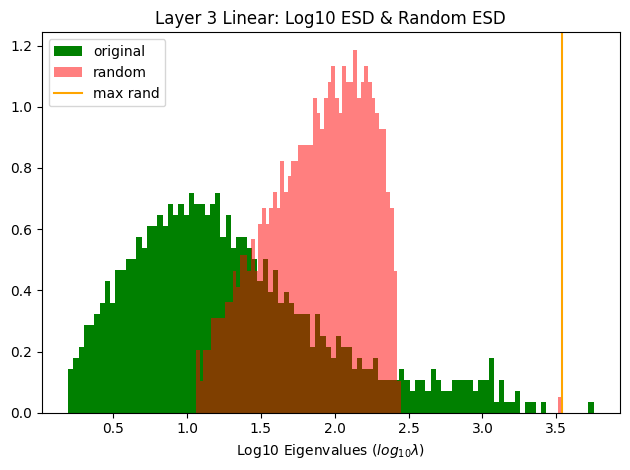

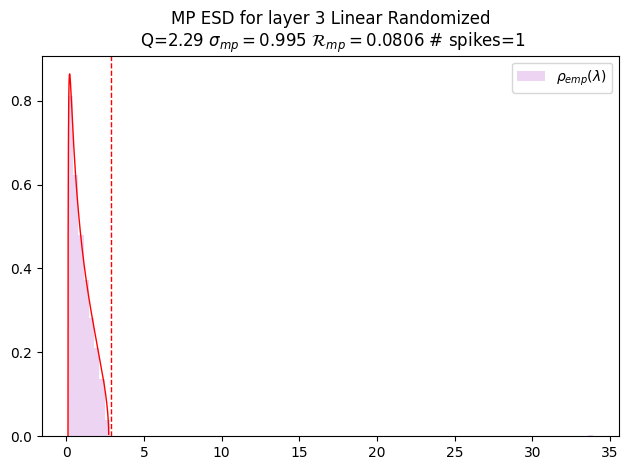

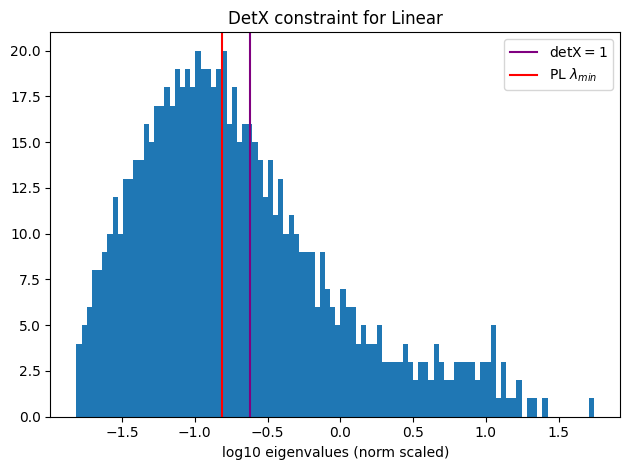

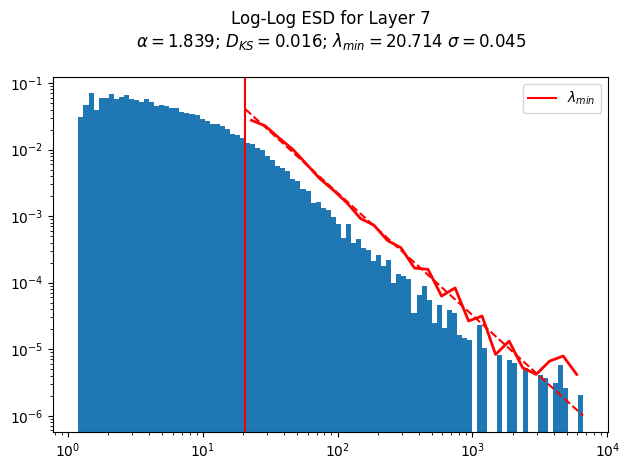

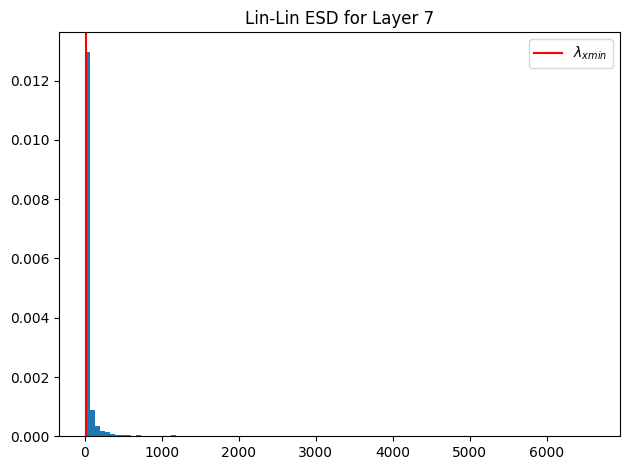

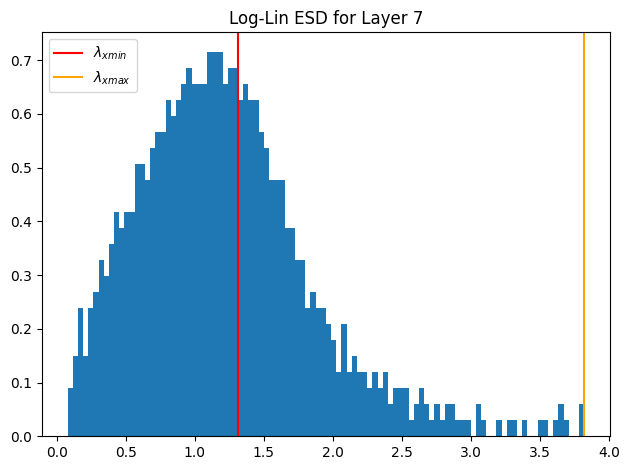

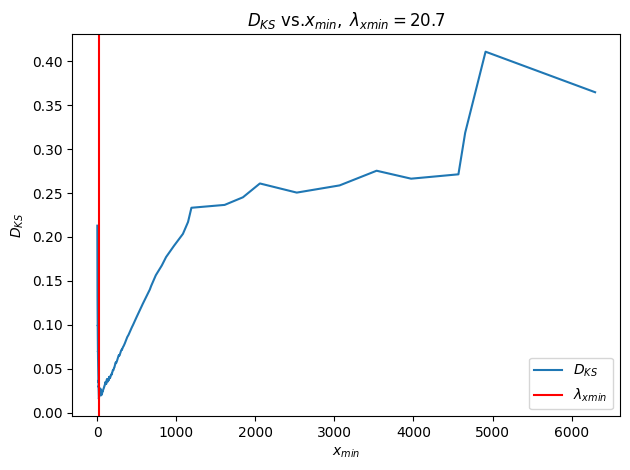

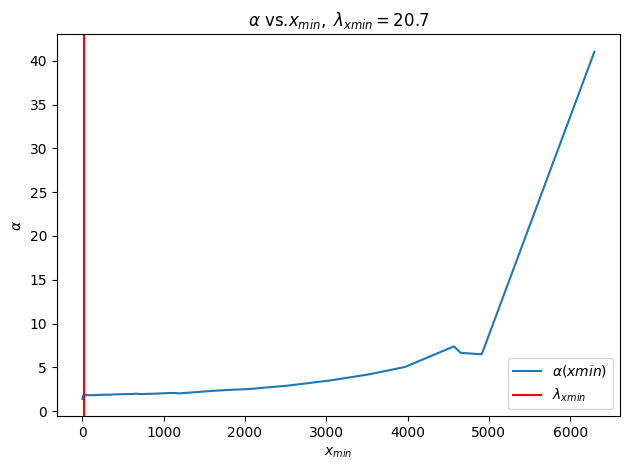

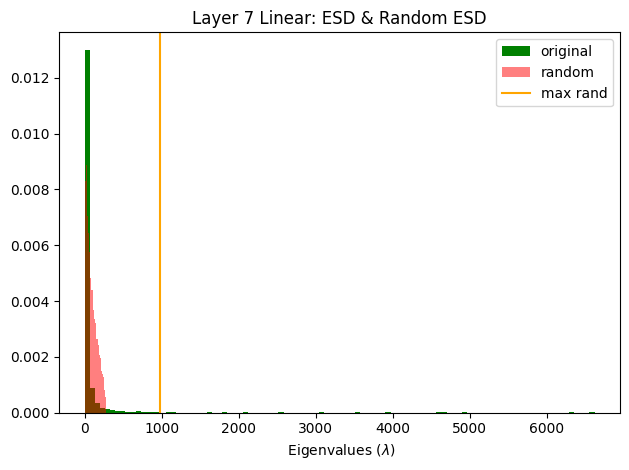

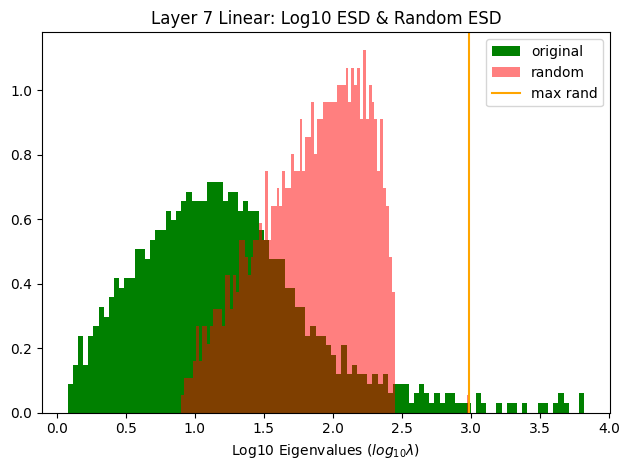

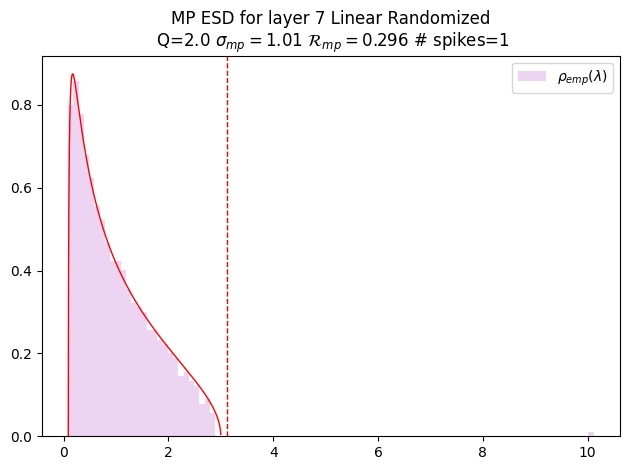

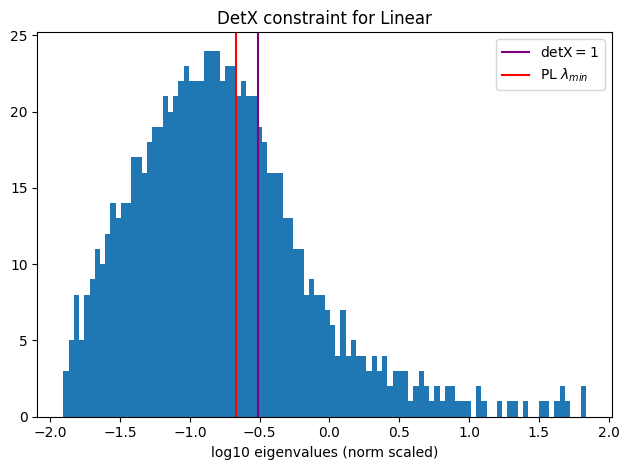

SMALL N PL FIT


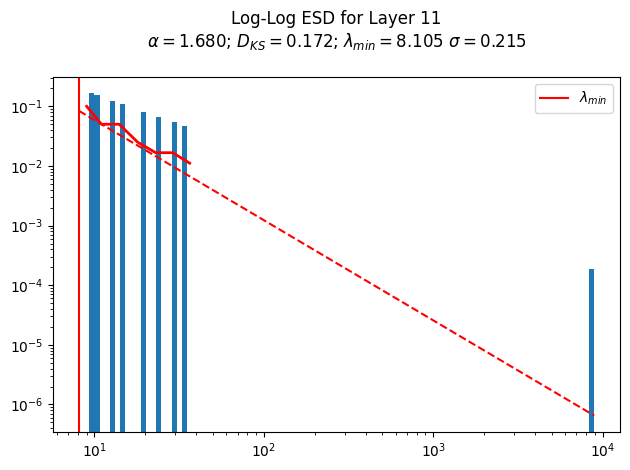

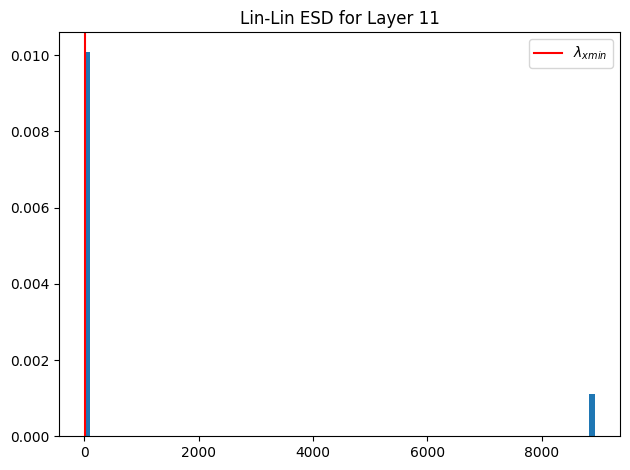

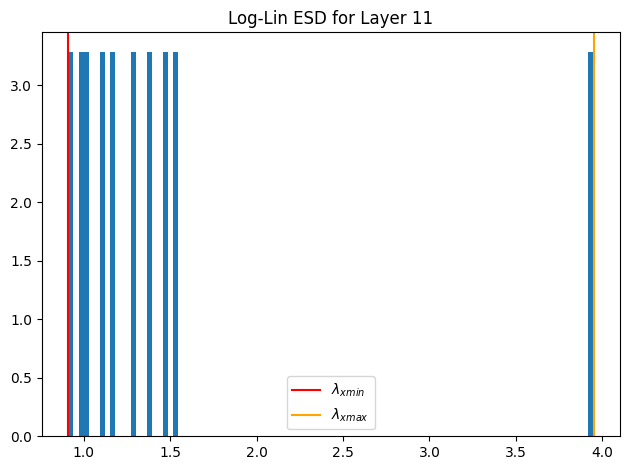

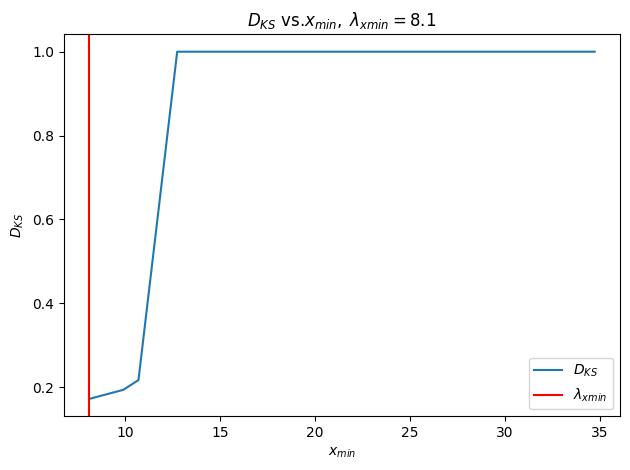

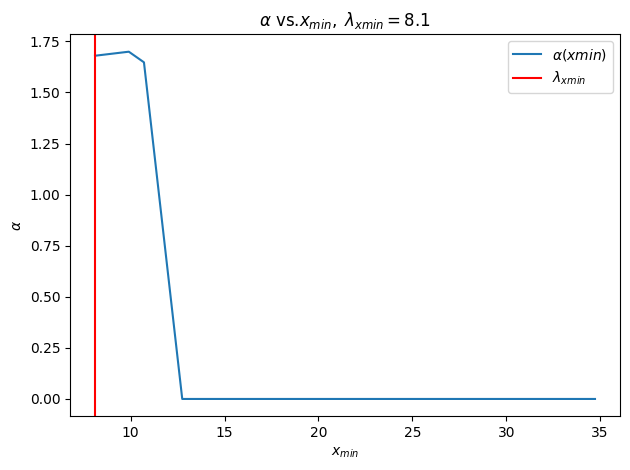

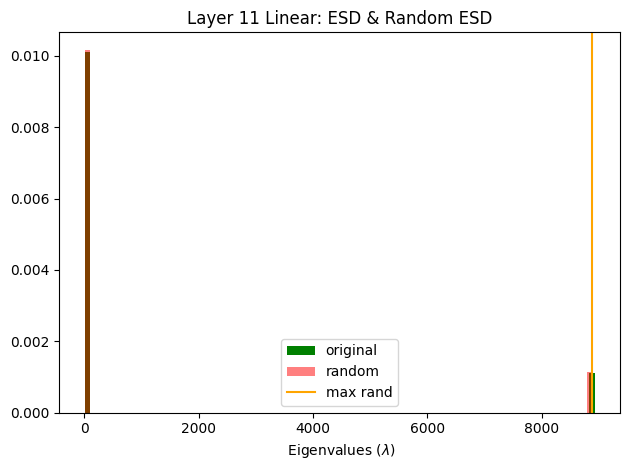

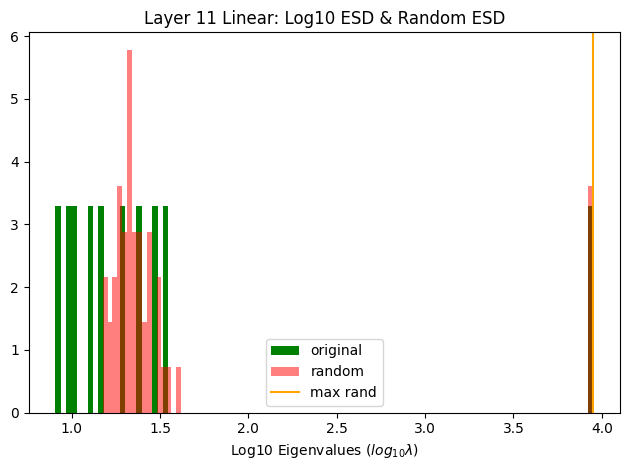

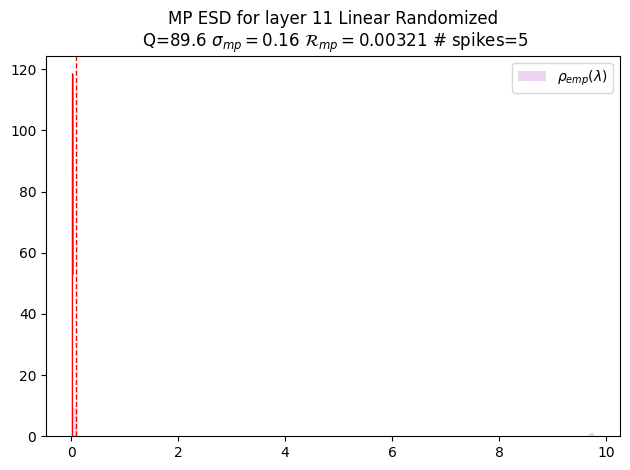

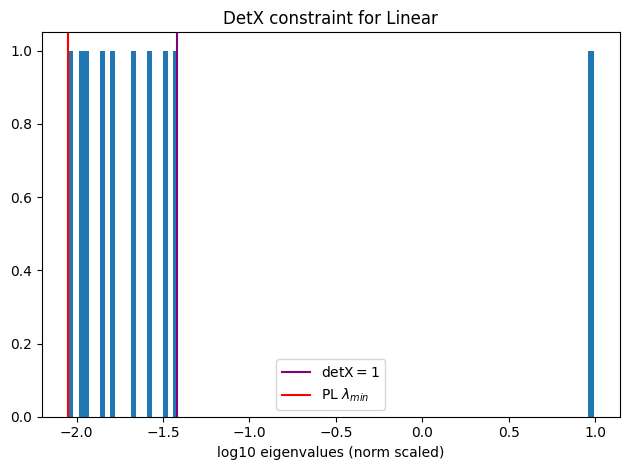

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,detX_num,detX_val,...,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,ww_maxdist,ww_softrank,xmax,xmin
0,3,Linear,0.028419,784,1792,2.285714,1.675972,6.290217,297,24.389637,...,14.113483,success,75.264154,1.251144,over-trained,0,2208.366747,0.610152,5664.692925,15.629916
1,7,Linear,0.015644,896,1792,2.000000,1.838692,7.025407,262,29.678982,...,13.056372,success,81.364652,1.094566,over-trained,0,5634.968836,0.148823,6620.206611,20.714097
2,11,Linear,0.171961,10,896,89.600000,1.679660,6.635556,2,34.727436,...,1.018398,success,94.464426,2.846867,over-trained,0,41.555086,0.995343,8923.527770,8.104649


<Figure size 640x480 with 0 Axes>

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import weightwatcher as ww

watcher = ww.WeightWatcher(model=model)
details = watcher.analyze(plot=True, detX=True, randomize=True)
details

Saved logs and plots in: ./runs/mlp3_mnist_dd


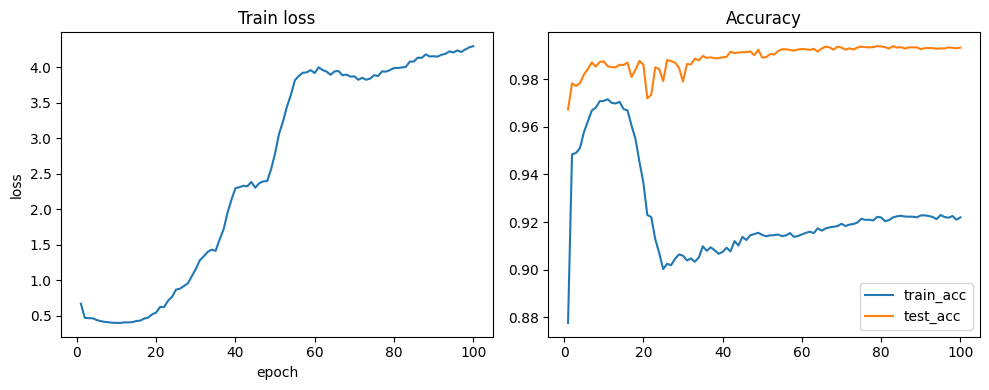

In [39]:
 # =========================
# Save logs & plot
# =========================
df = pd.DataFrame(history)
df.to_csv(os.path.join(hp.out_dir, "training_log.csv"), index=False)

# Combine WeightWatcher results from all epochs
ww_full = pd.concat(ww_history, ignore_index=True)
ww_full.to_csv(os.path.join(hp.out_dir, "weightwatcher_log.csv"), index=False)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(df["epoch"], df["train_loss"])
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Train loss")

plt.subplot(1,2,2)
plt.plot(df["epoch"], df["train_acc"], label="train_acc")
plt.plot(df["epoch"], df["test_acc"], label="test_acc")
plt.legend(); plt.title("Accuracy")

plt.tight_layout()
plt.savefig(os.path.join(hp.out_dir, "training_curves.png"), dpi=140)
print("Saved logs and plots in:", hp.out_dir)

Saved: ./runs/mlp3_mnist_dd/alpha_by_layer.csv


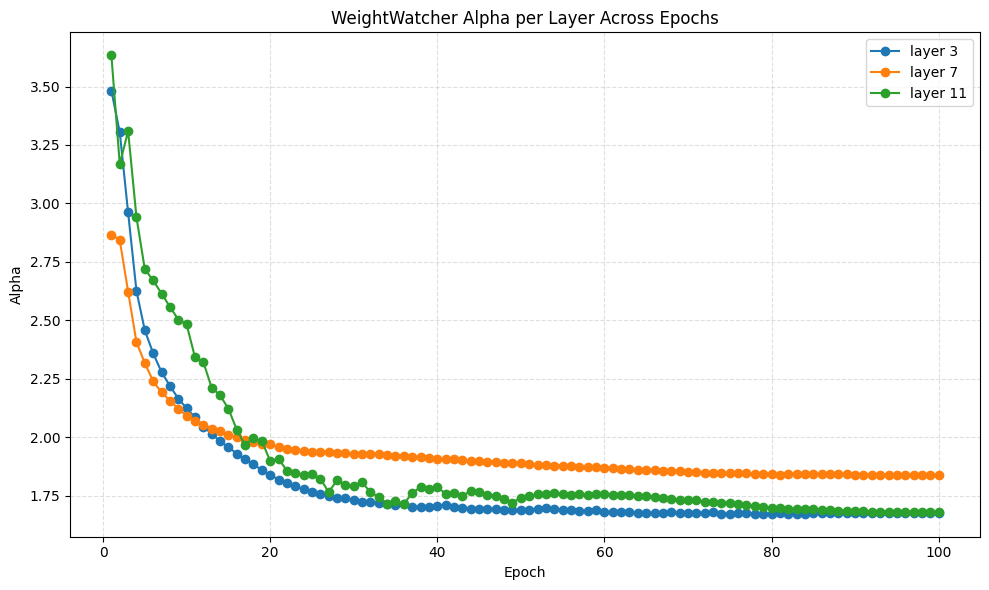

Saved: ./runs/mlp3_mnist_dd/alpha_by_layer.png


In [40]:
# === WeightWatcher Alpha Plot (single cell) ===
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Combine WeightWatcher results
ww_full = pd.concat(ww_history, ignore_index=True)

# 2. Keep only rows that contain alpha
ww_alpha = ww_full.dropna(subset=["alpha"])

# 3. Pivot into epoch × layer_id table
alpha_pivot = ww_alpha.pivot_table(
    index="epoch",
    columns="layer_id",
    values="alpha",
    aggfunc="mean"
)

# Save the pivot table
alpha_csv_path = os.path.join(hp.out_dir, "alpha_by_layer.csv")
alpha_pivot.to_csv(alpha_csv_path)
print("Saved:", alpha_csv_path)

# 4. Plot alpha evolution per layer
plt.figure(figsize=(10, 6))
for lid in alpha_pivot.columns:
    plt.plot(alpha_pivot.index, alpha_pivot[lid], marker="o", label=f"layer {lid}")

plt.xlabel("Epoch")
plt.ylabel("Alpha")
plt.title("WeightWatcher Alpha per Layer Across Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

alpha_plot_path = os.path.join(hp.out_dir, "alpha_by_layer.png")
plt.savefig(alpha_plot_path, dpi=140)
print("Saved:", alpha_plot_path)
plt.close()

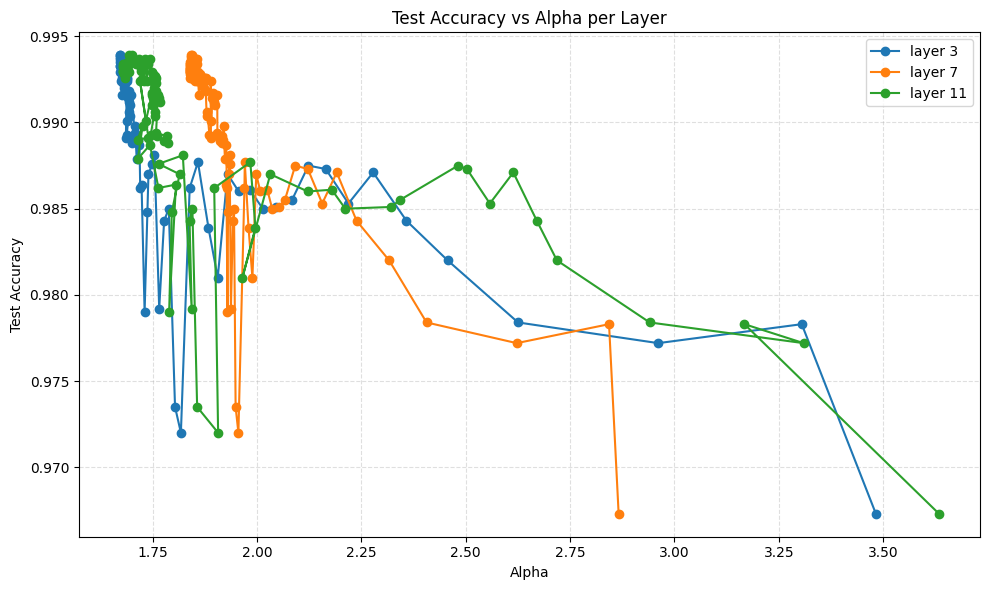

Saved: ./runs/mlp3_mnist_dd/alpha_vs_test_accuracy_flipped.png


In [41]:
# === Alpha vs Test Accuracy Plot (flipped axes, single cell) ===
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os

# Merge alpha table with test accuracy by epoch
alpha_acc = alpha_pivot.merge(
    df[["epoch", "test_acc"]],
    left_index=True,
    right_on="epoch",
    how="inner"
).set_index("epoch")

# Plot test accuracy vs α for each layer
plt.figure(figsize=(10, 6))

for lid in alpha_pivot.columns:
    plt.plot(
        alpha_acc[lid],         # x = alpha
        alpha_acc["test_acc"],  # y = test accuracy
        marker="o",
        label=f"layer {lid}"
    )

plt.xlabel("Alpha")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Alpha per Layer")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

out_path = os.path.join(hp.out_dir, "alpha_vs_test_accuracy_flipped.png")
plt.savefig(out_path, dpi=140)
plt.close()

print("Saved:", out_path)

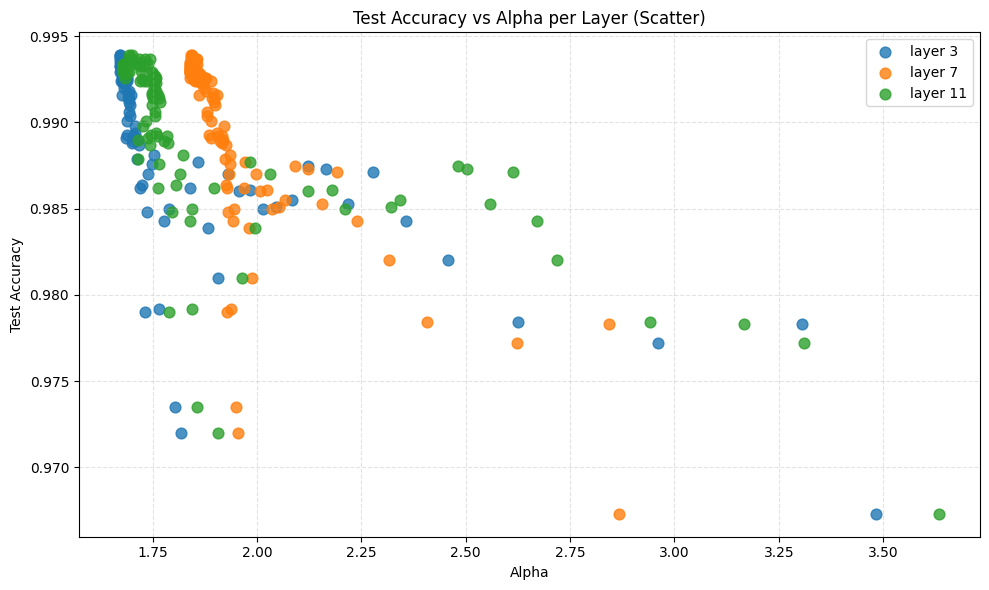

In [42]:
# === Alpha vs Test Accuracy Scatter Plot (single cell) ===
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os

# Merge alpha table with test accuracy by epoch
alpha_acc = alpha_pivot.merge(
    df[["epoch", "test_acc"]],
    left_index=True,
    right_on="epoch",
    how="inner"
).set_index("epoch")

# Scatter: α (x) vs test accuracy (y)
plt.figure(figsize=(10, 6))

for lid in alpha_pivot.columns:
    plt.scatter(
        alpha_acc[lid],         # x = alpha
        alpha_acc["test_acc"],  # y = test accuracy
        s=60,
        alpha=0.8,
        label=f"layer {lid}"
    )

plt.xlabel("Alpha")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Alpha per Layer (Scatter)")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

out_path = os.path.join(hp.out_dir, "alpha_vs_test_accuracy_scatter.png")
plt.savefig(out_path, dpi=140)
plt.close()

